In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torchvision import transforms
from sklearn.model_selection import KFold
from sklearn.feature_extraction.image import reconstruct_from_patches_2d
import pickle
from PIL import Image
import os
from sklearn.mixture import GaussianMixture
import torch
from sklearn.preprocessing import normalize

Hyper Parameter

In [107]:
k = 91
sigma = 30
m = 8

Simulation Question 1.

In [3]:
# download and load train MNIST dataset
train_set = MNIST('.\\train_data',train=True,transform=transforms.ToTensor(),download=True)
train_set_images = train_set.data.numpy()
train_set_labels = train_set.targets.numpy()

In [4]:
# choose random 1000 image
idxs = np.random.randint(0,len(train_set),1000)
pitch_images =  train_set_images[idxs,:,:]
pitch_labels = train_set_labels[idxs]

# generate patches
def generate_patches(images:np.ndarray, m:int)->np.ndarray:
    r,c = images[0,:,:].shape
    patches  = np.lib.stride_tricks.sliding_window_view(images,(m,m),(1,2)).reshape(-1,m**2)
    return patches
patches = generate_patches(pitch_images,m)

Simulation Question 2.

maximum of log-likelihhood =  42.5490981234305  and k =  91


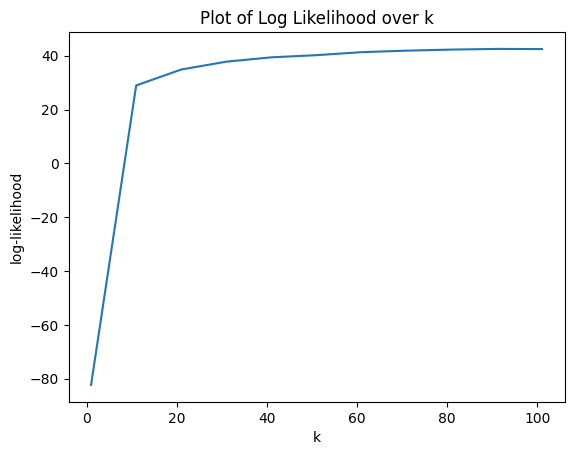

In [170]:
# cross validation over k(number of GMM component)
# for validation we just uses small number of patches(1/8 of patches) for cross validation because otherwise it takes very long time.
val_patches = patches[np.random.randint(np.random.randint(0,len(patches),50000)),:]
K = np.arange(1,102,10)
Rk = np.zeros(len(K))
counter = 0
for k in K:
    kf = KFold(n_splits=5)
    log_like = np.zeros(kf.get_n_splits())
    for i,(train_index,val_index) in enumerate(kf.split(val_patches)):
        gmm = GaussianMixture(k,random_state=0).fit(val_patches[train_index,:])
        log_like[i] = gmm.score(val_patches[val_index,:])
    Rk[counter] = log_like.mean()
    counter += 1
print("maximum of log-likelihhood = ",np.max(Rk),' and k = ',K[np.argmax(Rk)])
plt.plot(K,Rk)
plt.title("Plot of Log Likelihood over k")
plt.xlabel("k")
plt.ylabel("log-likelihood")
plt.show()

In [114]:
X = patches
gmm = GaussianMixture(k,random_state=0,warm_start=False,tol=0.01).fit(X)
# save this model
with open(f'GMM_k{k}_m{m}.pkl','wb') as f:
   pickle.dump(gmm,f)

Simulation Question 3.

In [108]:
def make_psd(matrixes):
   for Covar in matrixes:
      if np.linalg.det(Covar) == 0 :
         Covar += np.eye(len(Covar)) * 0.00001

In [109]:
# load model
def load_model(m):
   with open(f'GMM_k{k}_m{m}.pkl','rb') as f:
      gmm = pickle.load(f)
   Sigz = gmm.covariances_ # GMM covariance matrixes
   make_psd(Sigz)
   Perz = np.linalg.inv(Sigz)
   Muz = gmm.means_ # GMM mean vectores
   Pi = gmm.weights_ # GMM wieghts
   return Sigz, Perz, Muz, Pi

Sigz, Perz, Muz, Pi = load_model(m)
#loglikelihood = gmm.score(patches) # GMM log-likelihood
#print(loglikelihood)

In [110]:
# load images
def load_images(m):
    path_corrupted = f'./MNIST-m={m}/corrupted'
    path_original = f'./MNIST-m={m}/original'
    files_corrupted = os.listdir(path_corrupted)
    images = []
    original_images = []
    for file in files_corrupted:
        image = Image.open(os.path.join(path_corrupted,file))
        images.append(np.array(image))
        org_image = Image.open(os.path.join(path_original,file))
        original_images.append(np.array(org_image))
    images = np.array(images)
    original_images = np.array(original_images)
    _,r,c = images.shape
    # generate patches
    y = generate_patches(images,m)
    N = len(y)
    #load W
    W = np.load(f'./MNIST-m={m}/W.npy')
    return r,c,N,W,images,original_images,y
r,c,N,W,images,original_images,y = load_images(m)

In [111]:
#compute parametres of posterior
def posterior_parameters(sigma, W, Perz, Sigz, Muz, Pi):
    Per_y = 1/sigma**2 * np.identity(len(W)) # with size m**2 x m**2
    Perz_y = Perz + ((W.T) @ Per_y @ W) # with size k x m**2 x m**2
    Sigz_y = np.linalg.inv(Perz_y) # with size k x m**2 x m**2
    Muz_y = np.squeeze(Sigz_y @ np.transpose(np.repeat((W.T@Per_y @y.T).T[:,:,np.newaxis],k,axis=2) + np.diagonal(Perz@Muz.T,axis1=0,axis2=2),axes=(0,2,1))[:,:,:,np.newaxis],axis=3) # with size N x K x m**2
    det_Sigz = np.linalg.det(Sigz)
    C = Per_y @ W
    v = np.transpose(np.repeat(y[:,:,np.newaxis],k,axis=2) - W @ Muz.T,axes=(0,2,1))[:,:,:,np.newaxis] # N x K x m**2 x 1
    v_T = np.transpose(v,axes=(0,1,3,2)) # N x K x 1 x m**2
    Alpha = (np.log(Pi * np.sqrt(np.linalg.det(Sigz_y)) / np.sqrt(det_Sigz)) + np.squeeze(-1/2*v_T@(Per_y - C@Sigz_y@C.T)@v,axis=(2,3))) # N x k
    Alpha_T = Alpha.T
    Alpha_T -= np.max(Alpha_T,axis=0)
    Piz_y = (np.exp(Alpha_T) / np.sum(np.exp(Alpha_T),axis=0)).T # N x k
    return Perz_y, Sigz_y, Muz_y, Piz_y

Perz_y, Sigz_y, Muz_y, Piz_y = posterior_parameters(sigma,W,Perz,Sigz,Muz,Pi)

In [112]:
# compute approximation of MAP estimation
def MAP_estimate(Piz_y, Perz_y, Muz_y):
    Pz_y_k = Piz_y * (np.sqrt(np.linalg.det(Perz_y))) # N x k
    k_max = np.argmax(Pz_y_k,axis=1)
    new_patches = Muz_y[np.arange(0,N),k_max,:]
    return k_max, new_patches
k_max, new_patches = MAP_estimate(Piz_y,Perz_y,Muz_y)

In [113]:
# reconstruct image from its patches
def reconstruct_image(r,c,m,new_patches):
    patch_num_per_image = (r-m+1)*(c-m+1)
    temp = new_patches.reshape(-1,patch_num_per_image,m,m)
    new_images = []
    for image in temp:
        image1 = reconstruct_from_patches_2d(image,(r,c))
        new_images.append(image1)
    new_images = np.array(new_images)
    return new_images
new_images = reconstruct_image(r,c,m,new_patches)

Simulation Question 4.

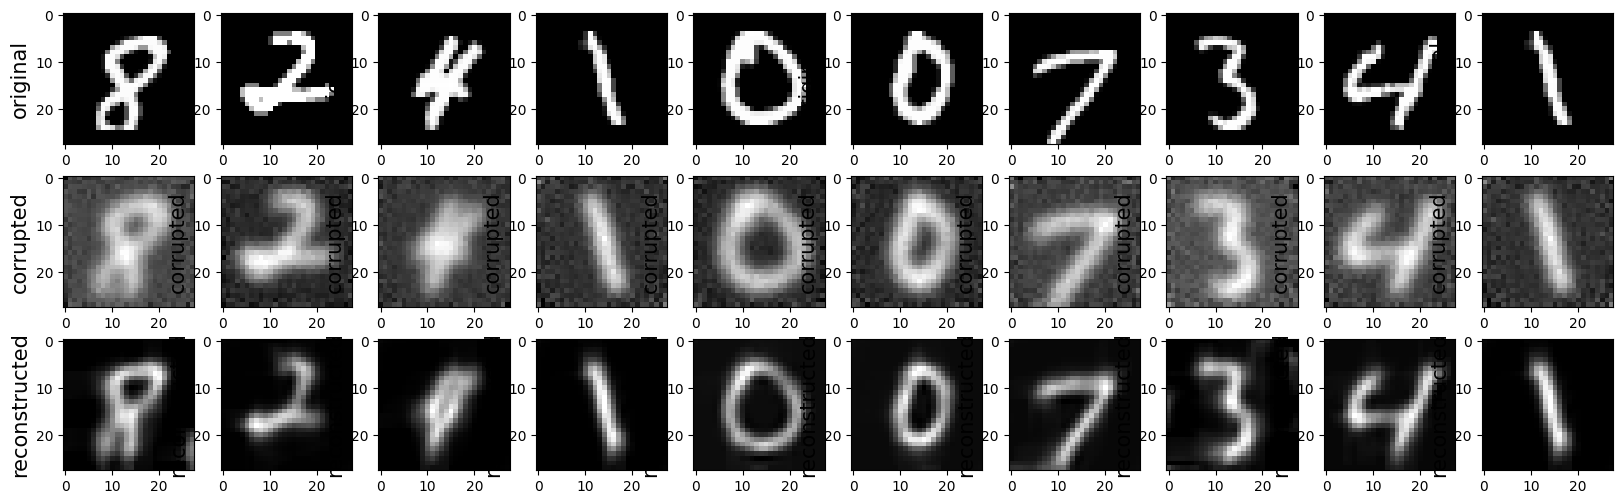

In [125]:
L = 10
plt.figure(figsize=(2*L,6))
indexes = np.random.randint(0,len(images),size=L)
i = 1
for index in indexes:
    plt.subplot(3,L,i)
    plt.imshow(original_images[index,:,:],'gray')
    plt.ylabel('original',fontsize=15)
    plt.subplot(3,L,i+L)
    plt.imshow(images[index,:,:],'gray')
    plt.ylabel('corrupted',fontsize=15)
    plt.subplot(3,L,i+2*L)
    plt.imshow(new_images[index,:,:],'gray')
    plt.ylabel('reconstructed',fontsize=15)
    i += 1
plt.show()

In [95]:
# compute cross validation for sigma based on Mean Squared Error
sigmas = np.array([5,10,20,30,50])
error = np.zeros(sigmas.shape)
N_images,_,_ = images.shape
for i,sigma in enumerate(sigmas):
    Perz_y, Sigz_y, Muz_y, Piz_y = posterior_parameters(sigma,W,Perz,Sigz,Muz,Pi)
    k_max, new_patches = MAP_estimate(Piz_y,Perz_y,Muz_y)
    new_images = reconstruct_image(r,c,m,new_patches)
    error[i] = 1/N_images * np.square(new_images-original_images).sum(axis=0).mean()

best_simga = sigmas[np.argmin(error)]
print('mean squared error : ',error)
print('best sigmas is : ',best_simga)

mean squared error :  [27525.18411425 25991.8649952  12806.15983091  7096.42572961
  3030.64224204]
best sigmas is :  50


In [76]:
# validation for m
""" we perform EM for all of m except 28 beacuse we got memory leakage exception. then we compute posterior for m = 4, 8 because for other m wee habe overflow in 
parametres of prior and posterior.(determinant of covariance matrixes is infinty so in computation of posterior parameter we got error and det 0 for Percision matrix.)
anyway we can just compare results for m=4,8 and its wonder that TA's do not realize that!!!! so after all we just need to compare result for m=4,8 and m=4 has
better results as you can see below.
"""
patch_size = np.array([4,8])
error = np.zeros(patch_size.shape)
for i,m in enumerate(patch_size):
    Sigz, Perz, Muz, Pi = load_model(m)
    r,c,N,W,images,original_images,y = load_images(m)
    N_images,_,_ = images.shape
    Perz_y, Sigz_y, Muz_y, Piz_y = posterior_parameters(sigma,W,Perz,Sigz,Muz,Pi)
    k_max, new_patches = MAP_estimate(Piz_y,Perz_y,Muz_y)
    new_images = reconstruct_image(r,c,m,new_patches)
    error[i] = 1/N_images * np.square(new_images-original_images).sum(axis=0).mean()
best_m = patch_size[np.argmin(error)]
print('mean squared error : ',error)
print('best sigmas is : ',best_m)


mean squared error :  [12125.11282606  7096.42572961]
best sigmas is :  8
